In [1]:
import warnings 
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import random
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,BatchNormalization
from keras.regularizers import l2
from xgboost import XGBRegressor

try:
    import gmplot
    import googlemaps
except ImportError:
    %pip install gmplot googlemaps 
    import gmplot
    import googlemaps

In [2]:
import sys
import os
from pathlib import Path
from dotenv import load_dotenv

parent_path = Path().cwd().parent  

#.env
dotenv_path = parent_path / '.env'
load_dotenv(dotenv_path=dotenv_path)

GOOGLE_MAPS_API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')

#src folder 
src_path = parent_path / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Now import from features package
from features.distance import calc_distance
from features.gmaps import extract_gmaps_data,merge_gmaps_data
from features.time import extract_time_features
from features.geolocation import clustering
from features.precipitation import extract_precipitation_data

In [3]:
train_df = pd.read_csv("../data/processed/eda_processed_train.csv",index_col="row_id")
test_df = pd.read_csv("../data/processed/eda_processed_test.csv",index_col="row_id")
combine = [train_df,test_df]

print("Train:",train_df.shape)
print("Test:",test_df.shape)
train_df.head()

Train: (140966, 6)
Test: (30000, 5)


,start_lng,start_lat,end_lng,end_lat,datetime,duration
row_id,,,,,,
0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0
1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0
2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,2620.0
3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0
4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,582.0


## Calculating Euclidean & Manhattan distance

In [4]:
for df in combine:
    df['manhattan'] = calc_distance(df,method='manhattan')
    df['euclidean'] = calc_distance(df,method='euclidean')

In [5]:
df.sample()

,start_lng,start_lat,end_lng,end_lat,datetime,manhattan,euclidean
row_id,,,,,,,
23190,-73.982323,40.775719,-73.975037,40.76144,2015-06-10 20:45:19,2400.604819,1704.093813


## Extract Google Maps data

In [6]:
# start = 0
# interval = 10000

# #process training data in batches
# while start < len(train_df):
#     print(f"Train: Now starting with batch of the {start}'s...")
#     train = train_df.loc[start:start+interval-1]
#     train = extract_gmaps_data(train,GOOGLE_MAPS_API_KEY,test=False)
#     start+=interval

# #process test data in batches
# start = 0
# while start < len(test_df):
#     print(f"Test: Now starting with batch of the {start}'s...")
#     test = test_df.loc[start:start+interval-1]
#     test = extract_gmaps_data(test,GOOGLE_MAPS_API_KEY,test=True)
#     start += interval


In [7]:
#merging multiple gmaps csv into gmaps train and test respectively
# merge_gmaps_data()

In [8]:
#importing gmaps data
gmaps_train_data = pd.read_csv("../data/processed/gmapsdata/gmaps_train_data.csv",index_col='row_id')
gmaps_test_data = pd.read_csv("../data/processed/gmapsdata/gmaps_test_data.csv",index_col='row_id')

train_df['gmaps_distance'] = gmaps_train_data['gmaps_distance']
train_df['gmaps_duration'] = gmaps_train_data['gmaps_duration']
train_df.dropna(axis=0,inplace=True)


test_df['gmaps_distance'] = gmaps_test_data['gmaps_distance']
test_df['gmaps_duration'] = gmaps_test_data['gmaps_duration']
test_df.dropna(axis=0,inplace=True)


In [9]:
train_df.sample(5)

,start_lng,start_lat,end_lng,end_lat,datetime,duration,manhattan,euclidean,gmaps_distance,gmaps_duration
row_id,,,,,,,,,,
86626,-73.975441,40.787182,-74.013672,40.714935,2015-08-28 10:22:39,1039.0,12298.354704,8664.652104,2029.0,415.0
77892,-73.982246,40.765400,-73.952278,40.778042,2015-09-05 00:41:48,464.0,4743.323503,2891.943111,10452.0,1644.0
6169,-73.973419,40.752613,-73.991150,40.750183,2015-01-11 05:05:46,470.0,2244.312254,1519.526431,785.0,226.0
61912,-122.419777,37.765343,-122.404845,37.784113,2012-09-01 05:30:00,300.0,3751.689479,2468.219411,2434.0,785.0
29961,-73.981110,40.774487,-73.988838,40.778049,2015-06-01 16:20:25,237.0,1256.797051,762.644056,15528.0,819.0


In [10]:
test_df.sample(5)

,start_lng,start_lat,end_lng,end_lat,datetime,manhattan,euclidean,gmaps_distance,gmaps_duration
row_id,,,,,,,,,
18641,-73.963928,40.765472,-73.981613,40.770412,2015-10-04 17:04:11,2518.603479,1589.183582,1997,492
14493,-73.987167,40.750599,-73.981171,40.758930,2015-12-05 16:20:55,1594.874345,1056.278470,1055,290
22625,-122.408617,37.780242,-122.504512,37.735625,2012-09-05 10:44:00,15641.724290,9792.697020,20871,1380
24555,-73.960594,40.765751,-73.976540,40.762398,2015-05-06 19:17:46,2148.354853,1395.319553,1977,572
706,-73.989449,40.762798,-73.992050,40.746658,2015-04-07 02:45:44,2086.238577,1810.034479,2365,558


sometimes there are chances that Google Maps API returns 0 distance for certain routes. Treasure Island in San Francisco has weird quirks where Google Maps fails to calculate the driving distance.

In [11]:
#Tresure Island fix
for df in combine:
    TI_df = df[df['gmaps_distance']==0].loc[df.manhattan>2000]
    #replacing them with manhattan distance
    df.loc[TI_df.index,"gmaps_distance"] = TI_df.manhattan
    #approximating gmaps_duration 
    df.loc[TI_df.index,"gmaps_duration"] = TI_df.manhattan/11.0

## Time Features

In [12]:
#add weekdays,hour,date column and drop datetime
#adding holiday column
extract_time_features(combine)
train_df.head()

,start_lng,start_lat,end_lng,end_lat,duration,manhattan,euclidean,gmaps_distance,gmaps_duration,weekday,hour,date,holiday
row_id,,,,,,,,,,,,,
0,-73.783279,40.644718,-73.963799,40.681320,1815.0,24169.910480,15778.616804,19322.0,2567.0,5,0,2015-01-09,0
1,-122.422385,37.789408,-122.419890,37.766692,300.0,2806.475682,2538.244354,2855.0,550.0,5,1,2012-09-14,0
2,-73.885292,40.773060,-74.000076,40.761360,2620.0,14080.134473,9764.679964,14693.0,1876.0,7,20,2015-04-19,0
3,-122.401603,37.788975,-122.410958,37.796447,360.0,1873.173072,1170.082524,2019.0,578.0,1,23,2012-09-03,0
4,-74.008728,40.714317,-74.006432,40.731720,582.0,2192.882649,1946.952973,2382.0,608.0,3,12,2015-01-21,0


In [13]:
train_df.columns

Index(['start_lng', 'start_lat', 'end_lng', 'end_lat', 'duration', 'manhattan',
       'euclidean', 'gmaps_distance', 'gmaps_duration', 'weekday', 'hour',
       'date', 'holiday'],
      dtype='object')

In [14]:
train_df.holiday.value_counts()

holiday
0    132603
1      3503
Name: count, dtype: int64

## Geolocations

In [15]:
clustering(train_df,test_df)

2025-09-29 04:02:21 [INFO] Preparing coordinates...
2025-09-29 04:02:21 [INFO] Preparing Clusters...
2025-09-29 04:02:54 [INFO] Preparing labels for cluster...
2025-09-29 04:02:54 [INFO] Adding cluster features to dataframes...


Number of clusters found: 5


2025-09-29 04:02:55 [INFO] Visualizing clusters...
2025-09-29 04:02:55 [INFO] Saved HTML Files in gmaps/...


In [16]:
train_df.columns

Index(['start_lng', 'start_lat', 'end_lng', 'end_lat', 'duration', 'manhattan',
       'euclidean', 'gmaps_distance', 'gmaps_duration', 'weekday', 'hour',
       'date', 'holiday', 'airport', 'citycenter', 'standalone'],
      dtype='object')

In [17]:
test_df.columns

Index(['start_lng', 'start_lat', 'end_lng', 'end_lat', 'manhattan',
       'euclidean', 'gmaps_distance', 'gmaps_duration', 'weekday', 'hour',
       'date', 'holiday', 'airport', 'citycenter', 'standalone'],
      dtype='object')

<Axes: >

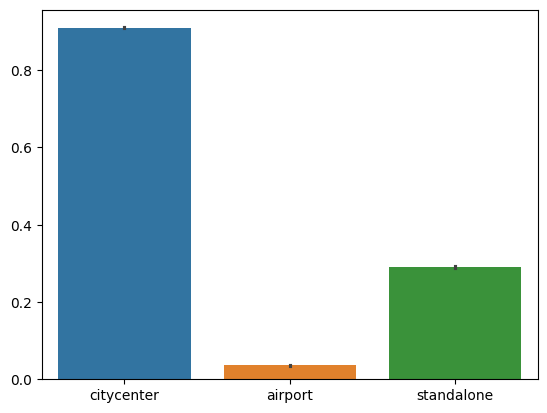

In [18]:
sns.barplot(train_df[['citycenter','airport','standalone']])

## Precipitation data

In [19]:
extract_precipitation_data(combine)

Added precipitation data successfully!


In [20]:
train_df = combine[0]
test_df = combine[1]
train_df.head()

,start_lng,start_lat,end_lng,end_lat,duration,manhattan,euclidean,gmaps_distance,gmaps_duration,weekday,hour,holiday,airport,citycenter,standalone,precipitation
0,-73.783279,40.644718,-73.963799,40.681320,1815.0,24169.910480,15778.616804,19322.0,2567.0,5,0,0,0,1,1,0.07
1,-122.422385,37.789408,-122.419890,37.766692,300.0,2806.475682,2538.244354,2855.0,550.0,5,1,0,0,1,1,0.00
2,-73.885292,40.773060,-74.000076,40.761360,2620.0,14080.134473,9764.679964,14693.0,1876.0,7,20,0,0,1,1,0.00
3,-122.401603,37.788975,-122.410958,37.796447,360.0,1873.173072,1170.082524,2019.0,578.0,1,23,0,0,1,0,0.00
4,-74.008728,40.714317,-74.006432,40.731720,582.0,2192.882649,1946.952973,2382.0,608.0,3,12,0,0,1,0,0.00


## Marking Outliers

In [21]:
#marking routing errors and short trips
for df in combine: 
    df['routing_error'] = np.zeros(df.index.shape)
    df['short_trip'] = np.zeros(df.index.shape)

    df.loc[(df.gmaps_distance > 500) & (df.manhattan < 50),"routing_error"] = 1
    df.loc[(df.gmaps_distance < 500) & (df.manhattan < 50),"short_trip"] = 1

In [22]:
train_df.sample(5)

,start_lng,start_lat,end_lng,end_lat,duration,manhattan,euclidean,gmaps_distance,gmaps_duration,weekday,hour,holiday,airport,citycenter,standalone,precipitation,routing_error,short_trip
15074,-122.410695,37.786932,-122.404983,37.787545,180.0,704.095779,507.124426,2022.0,431.0,5,23,0,0,1,0,0.00,0.0,0.0
101,-122.396803,37.785970,-122.422130,37.797692,720.0,4124.275814,2581.998531,1515.0,321.0,7,21,0,0,1,0,0.00,0.0,0.0
1438,-73.980614,40.785267,-73.976044,40.764423,841.0,2829.073539,2352.108191,6113.0,1400.0,6,16,0,0,1,0,0.02,0.0,0.0
116137,-122.433363,37.771705,-122.419018,37.799080,720.0,4644.249156,3298.361991,2083.0,613.0,7,0,0,0,1,1,0.00,0.0,0.0
17621,-73.992645,40.749252,-73.999771,40.720310,1637.0,4015.071394,3277.400668,5662.0,1129.0,1,22,0,0,1,0,0.00,0.0,0.0


In [23]:
test_df.sample(5)

,start_lng,start_lat,end_lng,end_lat,manhattan,euclidean,gmaps_distance,gmaps_duration,weekday,hour,holiday,airport,citycenter,standalone,precipitation,routing_error,short_trip
23027,-73.987495,40.750473,-73.961517,40.716312,6694.642857,4388.968601,11059,1584,3,0,0,0,1,1,0.0,0.0,0.0
16803,-73.973091,40.743610,-73.963287,40.716770,4079.191421,3100.165425,9594,1061,5,7,0,0,1,1,0.0,0.0,0.0
28863,-73.993408,40.751717,-73.975655,40.733170,4040.897516,2550.429602,3429,888,7,22,1,0,1,0,0.0,0.0,0.0
2956,-73.982048,40.728233,-73.964699,40.682468,7025.818342,5300.731487,7161,1489,2,17,0,0,1,1,0.0,0.0,0.0
14541,-73.988197,40.745953,-73.961868,40.763668,4902.955652,2969.547751,4147,1098,4,3,0,0,1,0,0.0,0.0,0.0


<Axes: title={'center': 'Pearson Correlation of Features'}>

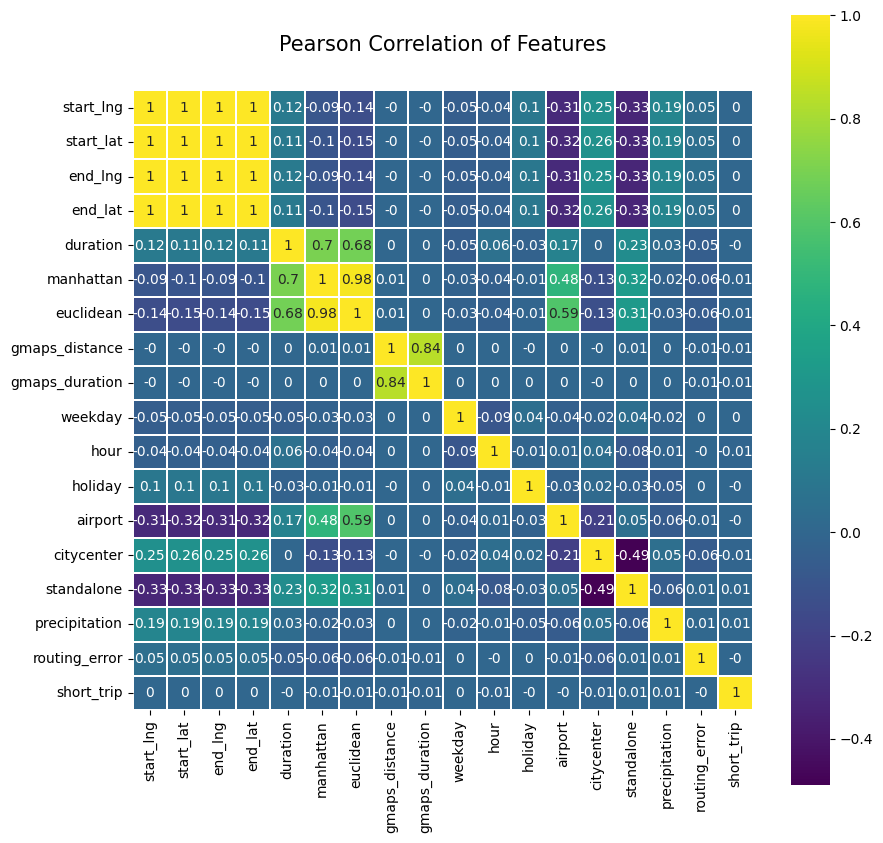

In [24]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features',y=1.05,size=15)
sns.heatmap(train_df.corr().round(2),linewidths=0.1,vmax=1.0, square=True, cmap=colormap,linecolor='white', annot=True)